In [1]:
from scipy.signal import butter,filtfilt
import csv, os ,math, pywt        ; from glob import glob
import matplotlib.pyplot as plt
import numpy as np     ; import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm  ; import seaborn as sns
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, \
QuantileTransformer, PowerTransformer, Normalizer

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터가 위치한 경로에서 모든 csv 파일 가져오기
train_test_set = sorted(glob('GNB/100_new/*.csv'))
validation_set = sorted(glob('GNB/35_new/*.csv'))

In [3]:
df_98_ = pd.DataFrame()
category = 0
for i, file in enumerate(train_test_set) :

    user_df = pd.read_csv(file)
    user_df = user_df[user_df.columns[:22]][:]

    lst_730   = user_df.columns[1:8].tolist()
    lst_850   = user_df.columns[8:15].tolist()
    lst_back  = user_df.columns[15:22].tolist()

    for idx in range(7) :

#         user_df[lst_730[idx]] = user_df[lst_730[idx]] - np.mean(user_df[lst_730[idx]]) #  DC OFFSET 제거
#         user_df[lst_850[idx]] = user_df[lst_850[idx]] - np.mean(user_df[lst_850[idx]]) #  DC OFFSET 제거

        user_df[lst_730[idx]] = user_df[lst_730[idx]]  # + user_df[lst_back[idx]] #+ 300
        user_df[lst_850[idx]] = user_df[lst_850[idx]]  # + user_df[lst_back[idx]] #+ 300

    user_df = user_df[user_df.columns[:15]][:]
    uid  = int(file.split('/')[-1].split('\\')[1].split(".")[0]) # 경로의 형태가 모두 다르기 때문에 자신의 경로 형태에 맞게 수정해야함.
    user_df.insert(0,'uid', uid)
    if i < 55:
        category = 'CN'
    elif  55<=i<85:
        category = 'MCI'
    elif  85<=i<99:
        category = "AD"
    user_df['Category'] = category

    df_98_ = pd.concat([df_98_,user_df])

uid_lst = list(set(df_98_.uid.unique().tolist()))

df_98 = pd.DataFrame()

for uid in uid_lst :

    df   = df_98_[df_98_.uid==uid]
    df_98 = pd.concat([df_98,df])

df_98 = df_98.reset_index(drop = True)

del df_98_

In [4]:
df_35_ = pd.DataFrame() # test data를 위해 데이터프레임 만들기

for i, file in enumerate(validation_set) :

    user_df = pd.read_csv(file)
    user_df = user_df[user_df.columns[:22]][:]

    lst_730   = user_df.columns[1:8].tolist()
    lst_850   = user_df.columns[8:15].tolist()
    lst_back  = user_df.columns[15:22].tolist()

    for idx in range(7) :

#         user_df[lst_730[idx]] = user_df[lst_730[idx]] - np.mean(user_df[lst_730[idx]]) #  DC OFFSET 제거
#         user_df[lst_850[idx]] = user_df[lst_850[idx]] - np.mean(user_df[lst_850[idx]]) #  DC OFFSET 제거

        user_df[lst_730[idx]] = user_df[lst_730[idx]]  #+ user_df[lst_back[idx]]# + 250
        user_df[lst_850[idx]] = user_df[lst_850[idx]]  #+ user_df[lst_back[idx]]# + 250
    user_df = user_df[user_df.columns[:15]][:]
    uid  = int(file.split('/')[-1].split('\\')[1].split(".")[0]) # 경로의 형태가 모두 다르기 때문에 자신의 경로 형태에 맞게 수정해야함.
    user_df.insert(0,'uid', uid)
    if i <= 5:
        category = 'AD'
        user_df['Category'] = category
        df_35_ = pd.concat([df_35_,user_df])
    elif  6<=i<21:
        category = 'CN'
        user_df['Category'] = category
        df_35_ = pd.concat([df_35_,user_df])
    elif  22<=i<=36:
        category = "MCI"
        user_df['Category'] = category
        df_35_ = pd.concat([df_35_,user_df])

#     user_df['Category'] = category
#     df_35_ = pd.concat([df_35_,user_df])

uid_lst = list(set(df_35_.uid.unique().tolist()))

df_35 = pd.DataFrame()

for uid in uid_lst :

    df   = df_35_[df_35_.uid==uid]
    df_35 = pd.concat([df_35,df])

df_35 = df_35.reset_index(drop = True)

del df_35_

def all_section_slice_data(df, ss_1,es_1,ss_2,es_2,ss_3,es_3,ss_4,es_4,ss_5,es_5) :

    user_lst = df.uid.unique()
    new_df   = pd.DataFrame()
    for i in user_lst :
        slice_df = pd.concat([df[df.uid==i][ss_1:es_1],df[df.uid==i][ss_2:es_2],df[df.uid==i][ss_3:es_3]
                              ,df[df.uid==i][ss_4:es_4],df[df.uid==i][ss_5:es_5]])
        new_df   = pd.concat([new_df,slice_df])
    return new_df

ss_1,es_1,ss_2,es_2,ss_3,es_3,ss_4,es_4,ss_5,es_5 = 0,1000,1400,2000,2400,3000,3400,4000,4400,5000

df_35 = all_section_slice_data(df_35,
                               ss_1,es_1,ss_2,es_2,ss_3,es_3,ss_4,es_4,ss_5,es_5).reset_index(drop=True)

In [5]:
def lowpassfilter(signal, thresh = 0, wavelet="db8"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    if len(signal) != len(reconstructed_signal) :
        reconstructed_signal = reconstructed_signal[1:]

    return reconstructed_signal[:]

wav_df_98 = pd.DataFrame()

for idx in tqdm(df_98.uid.unique()) :

    uid_1 = df_98[df_98.uid==idx]
    col_lst = uid_1.columns[2:-1].tolist()
    print("columns lst : {}".format(col_lst), end='\r')
    for j in col_lst :
        uid_1[j] = lowpassfilter(uid_1[j].values, 0.27)
    
    wav_df_98 = pd.concat([wav_df_98,uid_1])
wav_df_98 = wav_df_98.reset_index(drop=True)

  0%|          | 0/98 [00:00<?, ?it/s]

In [6]:
# 필터와 wavelet 변환 적용
'''
<wavelet 변한을 적용하는 이유>
신호의 값으로 해석하는것이 아닌 EDA 를 통해 높은 신호값이 많이 존재할수록 정산군에 속함.
따라서 t축(시간축)에 따라 신호가 변화하는 형태를 해석해야하기 때문에 wavelet 변환을 실시해야함.
'''
wav_df_35 = pd.DataFrame()

for idx in tqdm(df_35.uid.unique()) :

    uid_1 = df_35[df_35.uid==idx]
    col_lst = uid_1.columns[2:-1].tolist()
    print("columns lst : {}".format(col_lst), end='\r')
    for j in col_lst :
        uid_1[j] = lowpassfilter(uid_1[j].values, 0.27)

    wav_df_35 = pd.concat([wav_df_35,uid_1])
wav_df_35.head()
wav_df_35 = wav_df_35.reset_index(drop=True)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

<Axes: title={'center': '98 OD Data - User name : 14 -  730nm,850nm - 4Channel'}>

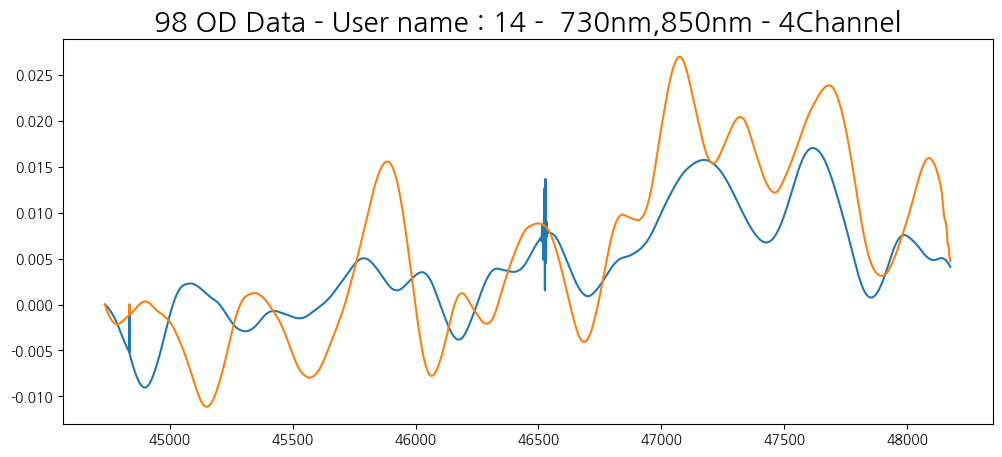

In [7]:
# 광학밀도변환
'''
<광학밀도변환(광필터)를 적용하는 이유>
알츠하이머 환자는 공통적으로 후각기능이 저하됨. 이 후각기능은 뇌신호에서 헤모글로빈의 농도에 따라 후각의 척도를 정함.
옥시 헤모글로빈과 디옥시헤모글로빈의 빛이 흡수된 정도와 반사된 정도값을 계산하여 각각의 농도를 얻을 수 있음.
신호에서 빛과 관련된 값을 추출하기 위해선 광밀도변환을 실시함.
'''
od_df_98 = pd.DataFrame()

for idx in tqdm(wav_df_98.uid.unique()) :

    raw = wav_df_98[wav_df_98.uid==idx].reset_index(drop=True)

    lst_730 = raw.columns[2:9].tolist()   #730 , 1~7채널
    lst_850 = raw.columns[9:16].tolist()  #850 , 1~7채널

    for jdx in lst_730 :

        ch         = jdx.split("_")[-1]
        ch730_name = "A_730_{}".format(ch)
        ch850_name = "A_850_{}".format(ch)
        print('process columns : {}, {}'.format(ch730_name,ch850_name), end='\r')
        data730 = raw[ch730_name]
        data850 = raw[ch850_name]

        base730 = data730.copy()
        base850 = data850.copy()

        # 신호는 측정이 시작되면 일정구간동안 엄청난 노이즈가 들어옴
        # 일정 구간이 지나면 정상적으로 측정이 시작됨.
        # 100만큼 구간을 잘라서 노이즈 처리를 실시
        base730[base730.index > 100] = np.mean(base730[:100])
        for ix in base730.index[:100].tolist() :
            base730[ix] = float(np.mean(data730[0:ix+1]))

        base850[base850.index > 100] = np.mean(base850[:100])
        for ix in base850.index[:100].tolist() :
            base850[ix] = float(np.mean(data850[0:ix+1]))

        # 비어-람베르트 법칙을 이용해서 광밀도 변환을 실시.
        raw[ch730_name] = np.log10(base730/data730)
        raw[ch850_name] = np.log10(base850/data850)


    od_df_98 = pd.concat([od_df_98,raw])

od_df_98 = od_df_98.reset_index(drop=True)

uids = 14

plt.title("98 OD Data - User name : {} -  730nm,850nm - 4Channel".format(uids),fontsize=20)
od_df_98[od_df_98.uid==uids].A_730_3.plot(figsize=(12,5))
od_df_98[od_df_98.uid==uids].A_850_3.plot(figsize=(12,5))

  0%|          | 0/36 [00:00<?, ?it/s]

<Axes: title={'center': '35 OD Data - User name : 13 -  730nm,850nm - 4Channel'}>

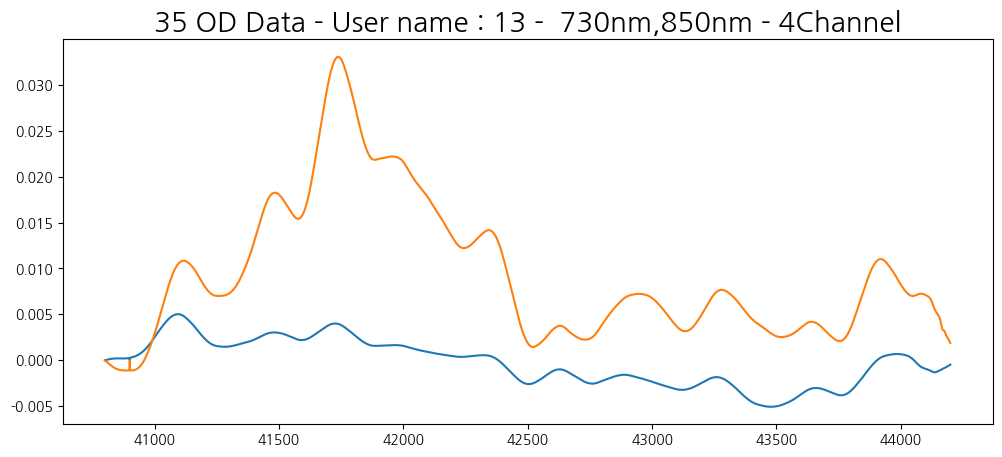

In [8]:
od_df_35 = pd.DataFrame()

for idx in tqdm(wav_df_35.uid.unique()) :

    raw = wav_df_35[wav_df_35.uid==idx].reset_index(drop=True)

    lst_730 = raw.columns[2:9].tolist()   #730 , 1~7채널
    lst_850 = raw.columns[9:16].tolist()  #850 , 1~7채널

    for jdx in lst_730 :

        ch         = jdx.split("_")[-1]
        ch730_name = "A_730_{}".format(ch)
        ch850_name = "A_850_{}".format(ch)
        print('process columns : {}, {}'.format(ch730_name,ch850_name), end='\r')
        data730 = raw[ch730_name]
        data850 = raw[ch850_name]

        base730 = data730.copy()
        base850 = data850.copy()

        base730[base730.index > 100] = np.mean(base730[:100])
        for ix in base730.index[:100].tolist() :
            base730[ix] = float(np.mean(data730[0:ix+1]))

        base850[base850.index > 100] = np.mean(base850[:100])
        for ix in base850.index[:100].tolist() :
            base850[ix] = float(np.mean(data850[0:ix+1]))

        raw[ch730_name] = np.log10(base730/data730) #/(separation_730[int(ch)])
        raw[ch850_name] = np.log10(base850/data850) #/(separation_850[int(ch)])

    od_df_35 = pd.concat([od_df_35,raw])

od_df_35 = od_df_35.reset_index(drop=True)


uids = 13

plt.title("35 OD Data - User name : {} -  730nm,850nm - 4Channel".format(uids),fontsize=20)
od_df_35[od_df_35.uid==uids].A_730_3.plot(figsize=(12,5))
od_df_35[od_df_35.uid==uids].A_850_3.plot(figsize=(12,5))

<Axes: title={'center': '98 Hb Data - User name : 14 -  hbo,hbr - 4Channel'}>

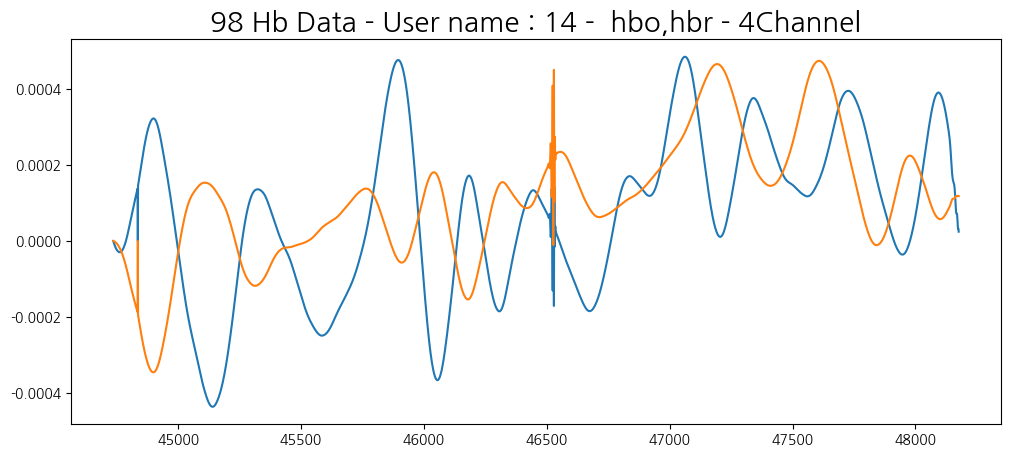

In [9]:
# 측정기기의 몰 흡광계수
e730_oxy = 2.1838
e730_deoxy = 9.5048
e850_oxy = 10.2470
e850_deoxy = 9.2819

e_c = (e730_oxy*e850_deoxy-e850_oxy*e730_deoxy)

separation_730 = np.array([4, 3.5, 3, 3.5, 4, 3, 1])
separation_850 = np.array([4, 3.5, 3, 3.5, 4, 3, 1])

hb_df_98 = pd.DataFrame()

for idx in od_df_98.uid.unique() :

    od = od_df_98[od_df_98.uid==idx].reset_index(drop=True)

    lst_730 = raw.columns[2:9].tolist()   #730 , 1~7채널
    lst_850 = raw.columns[9:16].tolist()  #850 , 1~7채널

    for jdx in lst_730 :

        ch         = jdx.split("_")[-1]

        ch730_name = "A_730_{}".format(ch)
        ch850_name = "A_850_{}".format(ch)

        hbo_name = "hbo_{}".format(str(int(ch)+1))
        hbr_name = "hbr_{}".format(str(int(ch)+1))

        OD730 = od[ch730_name]
        OD850 = od[ch850_name]

        hbo = (OD730*e850_deoxy-OD850*e730_deoxy)/(e_c * separation_850[int(ch)])
        hbr = (OD850*e730_oxy-OD730*e850_oxy)/(e_c * separation_850[int(ch)])
        od[ch730_name] = hbo
        od[ch850_name] = hbr

        od.rename(columns = {ch730_name:hbo_name, ch850_name:hbr_name}, inplace = True )
    hb_df_98 = pd.concat([hb_df_98,od])
hb_df_98 = hb_df_98.reset_index(drop=True)

uids = 14

plt.title("98 Hb Data - User name : {} -  hbo,hbr - 4Channel".format(uids),fontsize=20)
hb_df_98[hb_df_98.uid==uids].hbo_4.plot(figsize=(12,5))
hb_df_98[hb_df_98.uid==uids].hbr_4.plot(figsize=(12,5))

<Axes: title={'center': '35 Hb Data - User name : 25 -  hbo,hbr - 4Channel'}>

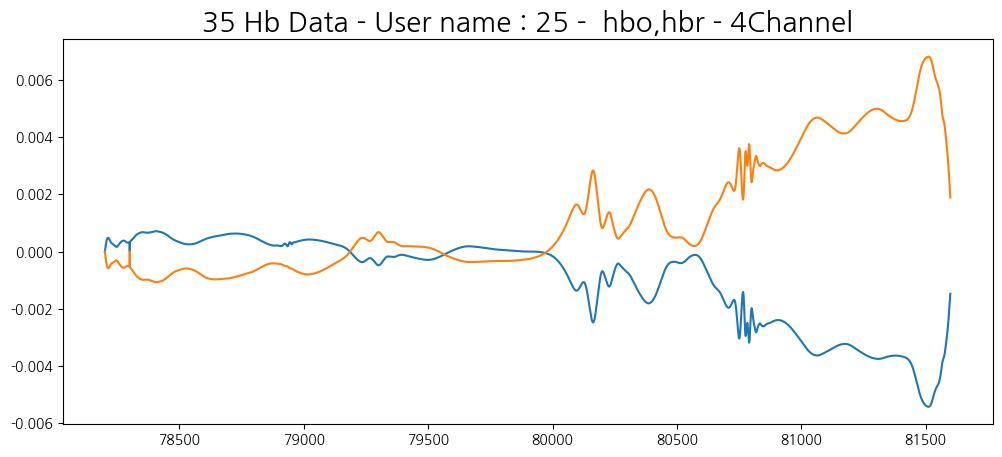

In [10]:
hb_df_35 = pd.DataFrame()

for idx in od_df_35.uid.unique() :

    od = od_df_35[od_df_35.uid==idx].reset_index(drop=True)

    lst_730 = raw.columns[2:9].tolist()   #730 , 1~7채널
    lst_850 = raw.columns[9:16].tolist()  #850 , 1~7채널

    for jdx in lst_730 :

        ch         = jdx.split("_")[-1]

        ch730_name = "A_730_{}".format(ch)
        ch850_name = "A_850_{}".format(ch)

        hbo_name = "hbo_{}".format(str(int(ch)+1))
        hbr_name = "hbr_{}".format(str(int(ch)+1))

        OD730 = od[ch730_name]
        OD850 = od[ch850_name]

        hbo = (OD730*e850_deoxy-OD850*e730_deoxy)/(e_c * separation_850[int(ch)])
        hbr = (OD850*e730_oxy-OD730*e850_oxy)/(e_c * separation_850[int(ch)])

        od[ch730_name] = hbo
        od[ch850_name] = hbr

        od.rename(columns = {ch730_name:hbo_name, ch850_name:hbr_name}, inplace = True )
    hb_df_35 = pd.concat([hb_df_35,od])
hb_df_35 = hb_df_35.reset_index(drop=True)

uids = 25

plt.title("35 Hb Data - User name : {} -  hbo,hbr - 4Channel".format(uids),fontsize=20)
hb_df_35[hb_df_35.uid==uids].hbo_4.plot(figsize=(12,5))
hb_df_35[hb_df_35.uid==uids].hbr_4.plot(figsize=(12,5))

<Axes: title={'center': 'cHb Data - User name : 14 -  cHbo,cHbr - 4Channel'}>

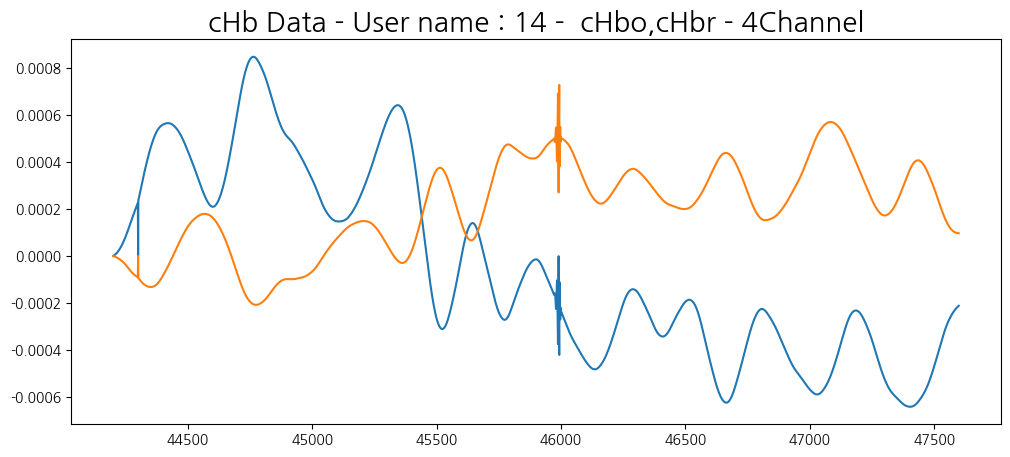

In [11]:
chb_df_98 = pd.DataFrame()

for idx in hb_df_98.uid.unique() :

    chb_df = pd.DataFrame()

    uid1  = hb_df_98[hb_df_98.uid==idx]

    hbo_lst  = uid1[uid1.columns[2:8]].columns
    hbr_lst  = uid1[uid1.columns[9:15]].columns

    for jdx in range(len(hbo_lst)) :

        cNIRS_HbO_constant = np.dot(uid1[hbo_lst[jdx]], uid1.hbo_7) / np.dot(uid1[hbo_lst[jdx]], uid1.hbo_7)
        cNIRS_Hb_constant  = np.dot(uid1[hbr_lst[jdx]], uid1.hbr_7) / np.dot(uid1[hbr_lst[jdx]], uid1.hbr_7)

        if cNIRS_HbO_constant>0:
            cHbO = uid1[hbo_lst[jdx]] - uid1.hbo_7 * float(cNIRS_HbO_constant)
        else :
            cHbO = uid1[hbo_lst[jdx]]
        if cNIRS_Hb_constant >0:
            cHb = uid1[hbr_lst[jdx]] - uid1.hbr_7 * float(cNIRS_Hb_constant)
        else :
            cHb = uid1[hbr_lst[jdx]]

        chb_df['c' + hbo_lst[jdx]] = cHbO[:3400]
        chb_df['c' + hbr_lst[jdx]] = cHb[:3400]

    chb_df.insert(0,'uid', idx)
    chb_df = chb_df[['uid','chbo_1','chbo_2','chbo_3','chbo_4','chbo_5','chbo_6'
                     ,'chbr_1','chbr_2','chbr_3','chbr_4','chbr_5','chbr_6']]
    chb_df['Category'] = uid1.Category.unique()[0]
    chb_df_98 = pd.concat([chb_df_98, chb_df])

chb_df_98 = chb_df_98.reset_index(drop=True)

pd1= chb_df_98.chbo_1 - chb_df_98.chbr_1
pd2= chb_df_98.chbo_2 - chb_df_98.chbr_2
pd3= chb_df_98.chbo_3 - chb_df_98.chbr_3
pd4= chb_df_98.chbo_4 - chb_df_98.chbr_4
pd5= chb_df_98.chbo_5 - chb_df_98.chbr_5
pd6= chb_df_98.chbo_6 - chb_df_98.chbr_6

lr01 = (pd1 + pd2 + pd3) - (pd4 + pd5 + pd6)

chb_df_98.insert(13, 'lr01', lr01)
chb_df_98.insert(14, 'dc_lr01', lr01 - np.mean(lr01))  # remove DC OFFSET
chb_df_98.insert(15, 'mean_chb', (pd1 + pd2 + pd3 +pd4 + pd5 + pd6) / 6)

uids = 14

plt.title("cHb Data - User name : {} -  cHbo,cHbr - 4Channel".format(uids),fontsize=20)
chb_df_98[chb_df_98.uid==uids].chbo_4.plot(figsize=(12,5))
chb_df_98[chb_df_98.uid==uids].chbr_4.plot(figsize=(12,5))

<Axes: title={'center': 'cHb Data - User name : 14 -  730nm,850nm - 4Channel'}>

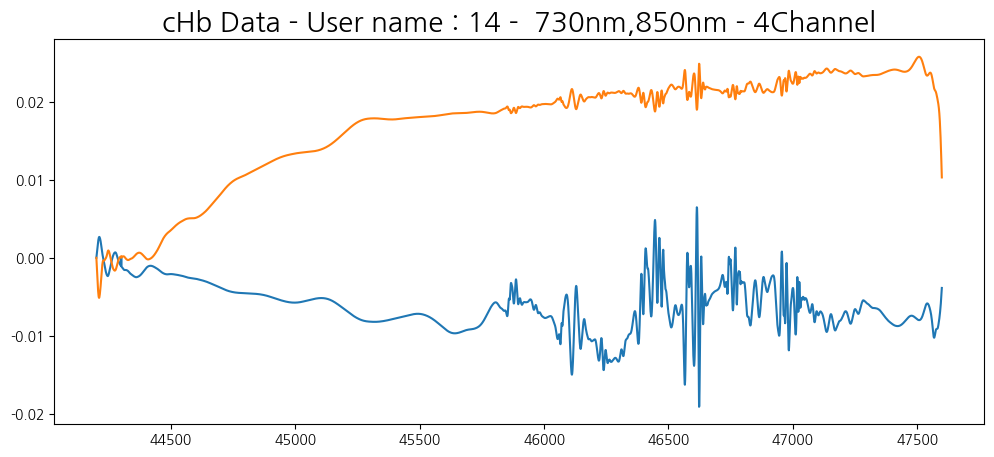

In [12]:
chb_df_35 = pd.DataFrame()

for idx in hb_df_35.uid.unique() :

    chb_df = pd.DataFrame()

    uid1  = hb_df_35[hb_df_35.uid==idx]

    hbo_lst  = uid1[uid1.columns[2:8]].columns
    hbr_lst  = uid1[uid1.columns[9:15]].columns

    for jdx in range(len(hbo_lst)) :

        cNIRS_HbO_constant = np.dot(uid1[hbo_lst[jdx]], uid1.hbo_7) / np.dot(uid1[hbo_lst[jdx]], uid1.hbo_7)
        cNIRS_Hb_constant  = np.dot(uid1[hbr_lst[jdx]], uid1.hbr_7) / np.dot(uid1[hbr_lst[jdx]], uid1.hbr_7)

        if cNIRS_HbO_constant>0:
            cHbO = uid1[hbo_lst[jdx]] - uid1.hbo_7 * float(cNIRS_HbO_constant)
        else :
            cHbO = uid1[hbo_lst[jdx]]
        if cNIRS_Hb_constant >0:
            cHb = uid1[hbr_lst[jdx]] - uid1.hbr_7 * float(cNIRS_Hb_constant)
        else :
            cHb = uid1[hbr_lst[jdx]]

        chb_df['c' + hbo_lst[jdx]] = cHbO[:3400]
        chb_df['c' + hbr_lst[jdx]] = cHb[:3400]

    chb_df.insert(0,'uid', idx)
    chb_df = chb_df[['uid','chbo_1','chbo_2','chbo_3','chbo_4','chbo_5','chbo_6'
                     ,'chbr_1','chbr_2','chbr_3','chbr_4','chbr_5','chbr_6']]
    chb_df['Category'] = uid1.Category.unique()[0]
    chb_df_35 = pd.concat([chb_df_35, chb_df])

chb_df_35 = chb_df_35.reset_index(drop=True)

pd1= chb_df_35.chbo_1 - chb_df_35.chbr_1
pd2= chb_df_35.chbo_2 - chb_df_35.chbr_2
pd3= chb_df_35.chbo_3 - chb_df_35.chbr_3
pd4= chb_df_35.chbo_4 - chb_df_35.chbr_4
pd5= chb_df_35.chbo_5 - chb_df_35.chbr_5
pd6= chb_df_35.chbo_6 - chb_df_35.chbr_6

lr01 = (pd1 + pd2 + pd3) - (pd4 + pd5 + pd6)

chb_df_35.insert(13, 'lr01', lr01)
chb_df_35.insert(14, 'dc_lr01', lr01 - np.mean(lr01))  # remove DC OFFSET
chb_df_35.insert(15, 'mean_chb', (pd1 + pd2 + pd3 +pd4 + pd5 + pd6) / 6)

uids = 14

plt.title("cHb Data - User name : {} -  730nm,850nm - 4Channel".format(uids),fontsize=20)
chb_df_35[chb_df_35.uid==uids].chbo_4.plot(figsize=(12,5))
chb_df_35[chb_df_35.uid==uids].chbr_4.plot(figsize=(12,5))

<Axes: >

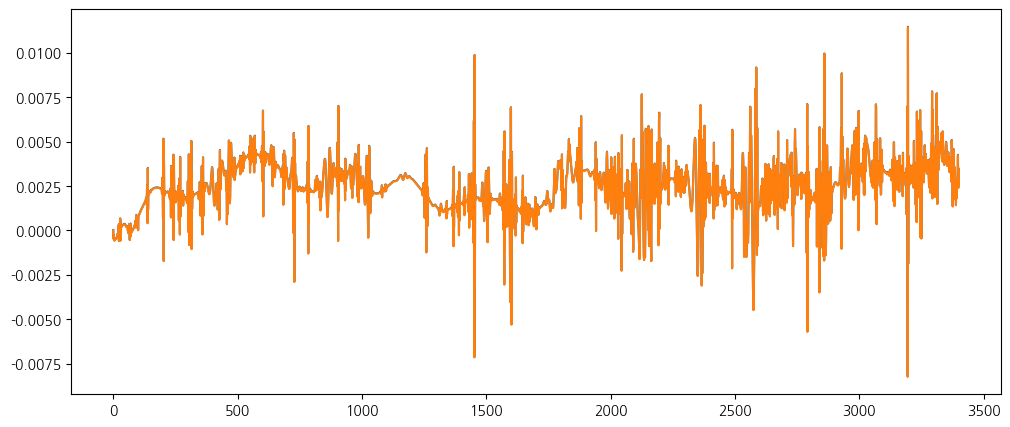

In [13]:
chb_df_98[chb_df_98.uid==1].dc_lr01.plot(figsize=(12,5))
chb_df_98[chb_df_98.uid==1].lr01.plot(figsize=(12,5))

<Axes: >

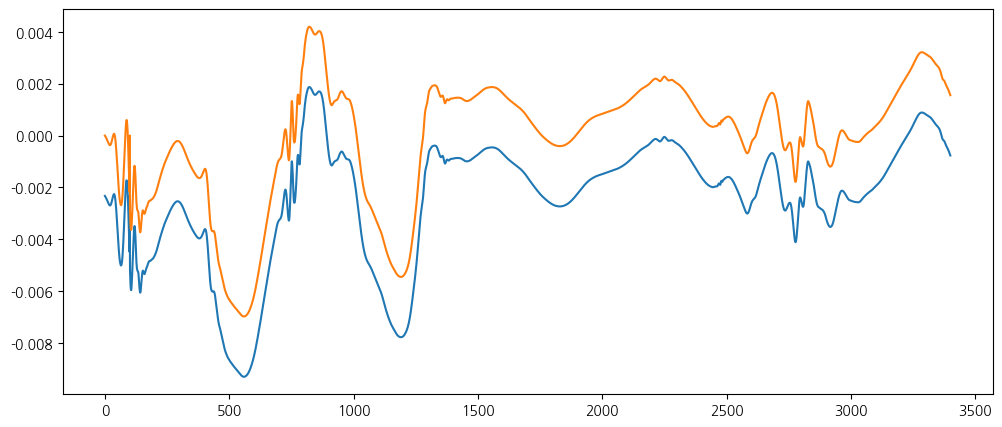

In [14]:
chb_df_35[chb_df_35.uid==1].dc_lr01.plot(figsize=(12,5))
chb_df_35[chb_df_35.uid==1].lr01.plot(figsize=(12,5))

In [15]:
# NaN값이 있는 유저 확인 후 제거

null_uid = chb_df_98[chb_df_98.lr01.isna()].uid.unique()
print('98 - Nan user Index : {}'.format(null_uid))
for i in null_uid :
      chb_df_98 = chb_df_98[chb_df_98.uid != i]

null_uid = chb_df_35[chb_df_35.lr01.isna()].uid.unique()
print('35 - Nan user Index : {}'.format(null_uid))
for i in null_uid :
      chb_df_35 = chb_df_35[chb_df_35.uid != i]

98 - Nan user Index : [19]
35 - Nan user Index : [ 7 29]


<Axes: title={'center': 'cHb Data - User name : 14 -  lr01'}>

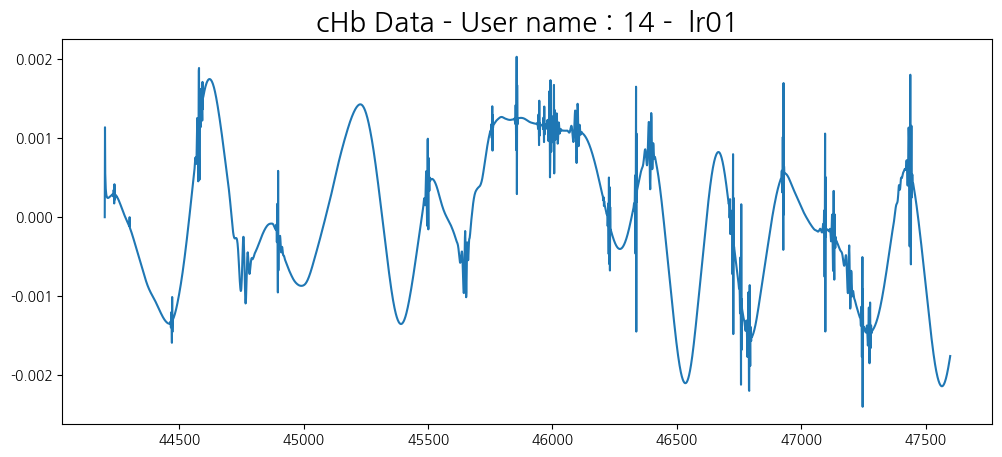

In [16]:
uids = 14

plt.title("cHb Data - User name : {} -  lr01".format(uids),fontsize=20)
chb_df_98[chb_df_98.uid==uids].lr01.plot(figsize=(12,5))

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, \
QuantileTransformer, PowerTransformer, Normalizer
from sklearn.metrics import precision_score , recall_score ,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier

In [18]:
print("사용할 수 있는 피처 목록 : \n{}".format(chb_df_98.columns[1:-1].tolist()))

사용할 수 있는 피처 목록 : 
['chbo_1', 'chbo_2', 'chbo_3', 'chbo_4', 'chbo_5', 'chbo_6', 'chbr_1', 'chbr_2', 'chbr_3', 'chbr_4', 'chbr_5', 'chbr_6', 'lr01', 'dc_lr01', 'mean_chb']


In [19]:
chb_df_98.to_csv('real_train_LPF.csv')
chb_df_35.to_csv('real_test_LPF.csv')

In [20]:
train = chb_df_98.copy()
test  = chb_df_35.copy()

feature  = 'lr01'

time_seq = 3400 # or len(chb_100[chb_100.uid==1])

train_user_num = len(train.uid.unique())  # 학습 데이터 수
test_user_num = len(test.uid.unique())    # 테스트 데이터 수

x_train_hbo = np.array(train[feature].values).reshape(train_user_num, time_seq) # 넘파이 변환
y_train = np.array(train.drop_duplicates(['uid']).Category.values)                    # 라벨 목록

x_test_hbo = np.array(test[feature].values).reshape(test_user_num, time_seq)     # 넘파이 변환
y_test = np.array(test.drop_duplicates(['uid']).Category.values)                      # 라벨 목록


########## 데이터 스케일링 주석 해제 후 사용

# scaler = PowerTransformer()  # 피처를 정규 분포 형태로 데이터 변환
# scaler = StandardScaler()    # 평균 0, 분산 1로 조정하여 변환  (분류에 적합) - 이상치에 민감
scaler = Normalizer()        # 피처의 모든 길이가 1이 되도록 조정
# scaler = MinMaxScaler()      # 모든 값을 0과 1사이에 존재하도록 변환         - 이상치에 민감
# scaler = RobustScaler()      # 중앙값과 사분위 값을 이용하여 데이터 변환 (이상치에 효과적)
# scaler = QuantileTransformer(output_distribution='normal')
# 1000개 분위를 사용하여 데이터를 균등분포 하도록 변환  Robust와 유사하면서 0~1사이로 데이터 압축

x_train_hbo = scaler.fit_transform(x_train_hbo)   # 스케일링 학습 데이터 적용
x_test_hbo  = scaler.transform(x_test_hbo)        # 테스트 데이터에 그대로 적용

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

((97, 3400), (97,), (34, 3400), (34,))

랜덤 포레스트 

훈련 세트 
 - 정확도(acc)         : 1.000
 - 정밀도(precision)   : 1.000
 - 재현율(recall)      : 1.000
 - AUC 점수            : 1.000
테스트 세트 
 - 정확도(acc)         : 0.265
 - 정밀도(precision)   : 0.107
 - 재현율(recall)      : 0.214
 - AUC 점수            : 0.416


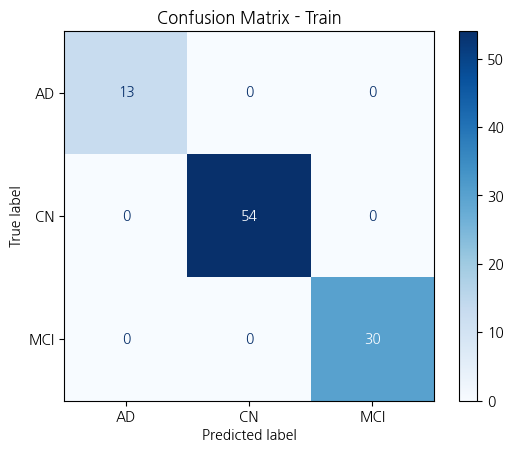

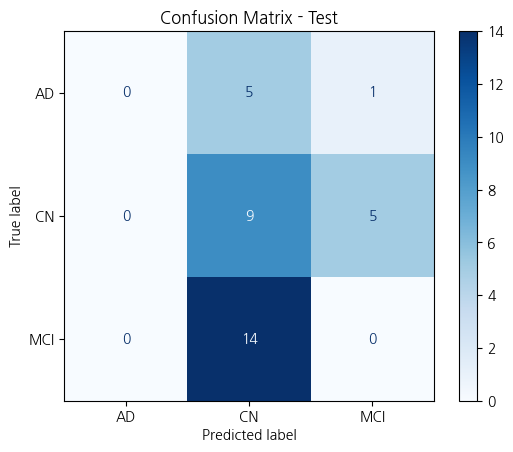

In [21]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_hbo, y_train)

print("랜덤 포레스트 \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(rf.score(x_train_hbo, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, rf.predict(x_train_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, rf.predict(x_train_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, rf.predict_proba(x_train_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(rf, # 분류 모델
                             x_train_hbo, y_train, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Train')



print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(rf.score(x_test_hbo, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, rf.predict(x_test_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, rf.predict(x_test_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, rf.predict_proba(x_test_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(rf, # 분류 모델
                             x_test_hbo, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Test')

def plot_feature_importances(model):
    n_features = x_train_hbo.data.shape[1]
    plt.barh(model.feature_importances_,range(n_features), align='center')
    plt.yticks(np.arange(n_features))
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

디시젼트리 

훈련 세트 
 - 정확도(acc)         : 1.000
 - 정밀도(precision)   : 1.000
 - 재현율(recall)      : 1.000
 - AUC 점수            : 1.000
테스트 세트 
 - 정확도(acc)         : 0.235
 - 정밀도(precision)   : 0.099
 - 재현율(recall)      : 0.190
 - AUC 점수            : 0.379


Text(0.5, 1.0, 'Confusion Matrix - Test')

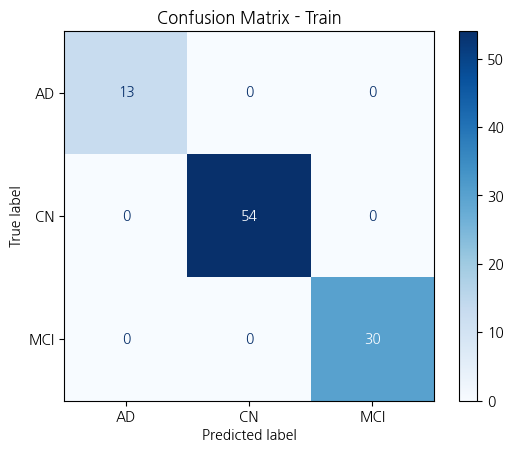

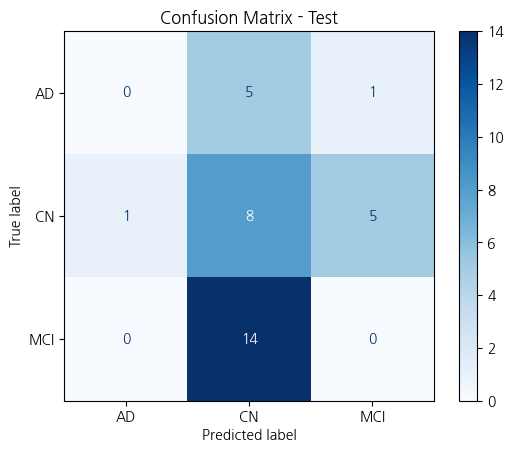

In [22]:
gbc = GradientBoostingClassifier(max_depth= 6, random_state=79 , learning_rate = 0.01) # 기본값: max_depth=3, learning_rate=0.1

gbc.fit(x_train_hbo, y_train)

print("디시젼트리 \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(gbc.score(x_train_hbo, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, gbc.predict(x_train_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, gbc.predict(x_train_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, gbc.predict_proba(x_train_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(gbc, # 분류 모델
                             x_train_hbo, y_train, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Train')



print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(gbc.score(x_test_hbo, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, gbc.predict(x_test_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, gbc.predict(x_test_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, gbc.predict_proba(x_test_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(gbc, # 분류 모델
                             x_test_hbo, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Test')

GaussianNB 

훈련 세트 
 - 정확도(acc)         : 0.454
 - 정밀도(precision)   : 0.519
 - 재현율(recall)      : 0.545
 - AUC 점수            : 0.712
테스트 세트 
 - 정확도(acc)         : 0.353
 - 정밀도(precision)   : 0.368
 - 재현율(recall)      : 0.349
 - AUC 점수            : 0.523


Text(0.5, 1.0, 'Confusion Matrix - Test')

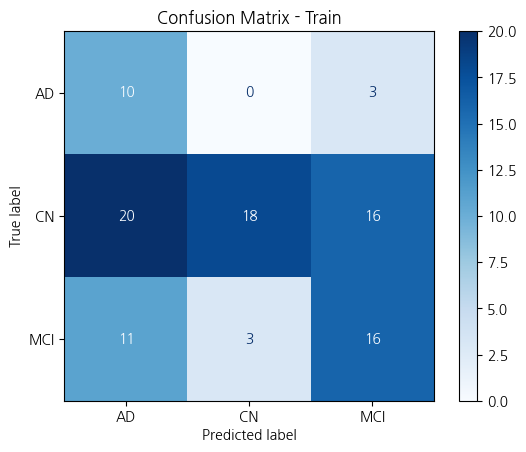

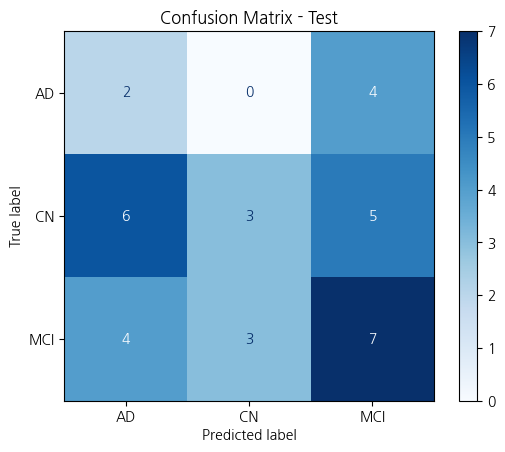

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train_hbo, y_train)

print("GaussianNB \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(gnb.score(x_train_hbo, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, gnb.predict(x_train_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, gnb.predict(x_train_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, gnb.predict_proba(x_train_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(gnb, # 분류 모델
                             x_train_hbo, y_train, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Train')



print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(gnb.score(x_test_hbo, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, gnb.predict(x_test_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, gnb.predict(x_test_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, gnb.predict_proba(x_test_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(gnb, # 분류 모델
                             x_test_hbo, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Test')

디시젼트리 

훈련 세트 
 - 정확도(acc)         : 0.918
 - 정밀도(precision)   : 0.931
 - 재현율(recall)      : 0.863
 - AUC 점수            : 0.964
테스트 세트 
 - 정확도(acc)         : 0.265
 - 정밀도(precision)   : 0.281
 - 재현율(recall)      : 0.246
 - AUC 점수            : 0.423


Text(0.5, 1.0, 'Confusion Matrix - Test')

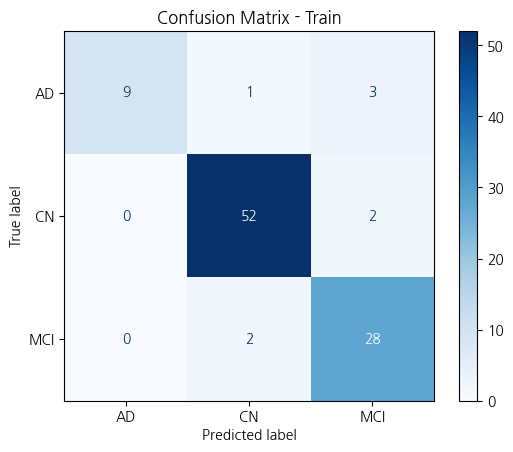

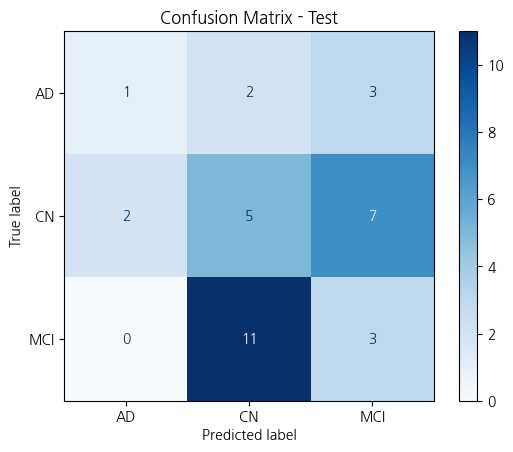

In [24]:
from sklearn import tree

tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=444)
tree.fit(x_train_hbo, y_train)

print("디시젼트리 \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(tree.score(x_train_hbo, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, tree.predict(x_train_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, tree.predict(x_train_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, tree.predict_proba(x_train_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(tree, # 분류 모델
                             x_train_hbo, y_train, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Train')



print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(tree.score(x_test_hbo, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, tree.predict(x_test_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, tree.predict(x_test_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, tree.predict_proba(x_test_hbo), multi_class='ovr') ) , end='\n')


label=['AD', 'CN', 'MCI'] # 라벨 설정
plot = plot_confusion_matrix(tree, # 분류 모델
                             x_test_hbo, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Test')

xgboost 

훈련 세트 
 - 정확도(acc)         : 1.000
 - 정밀도(precision)   : 1.000
 - 재현율(recall)      : 1.000
 - AUC 점수            : 1.000
테스트 세트 
 - 정확도(acc)         : 0.235
 - 정밀도(precision)   : 0.163
 - 재현율(recall)      : 0.190
 - AUC 점수            : 0.390


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

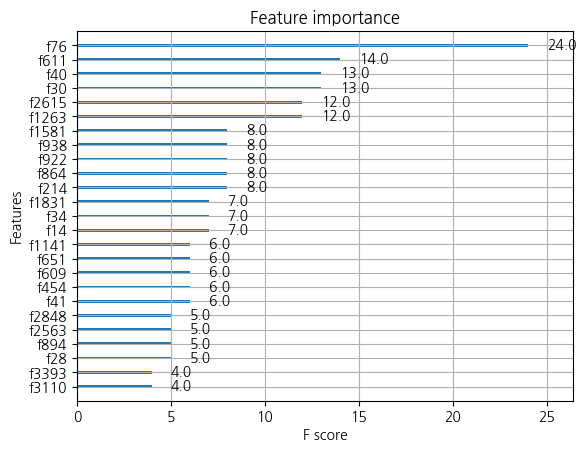

In [25]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import preprocessing

le    = preprocessing.LabelEncoder()        ## 라벨인코딩 기능
y     = le.fit_transform(y_train)
y_2   = le.transform(y_test)


xgb = XGBClassifier(random_state=10)
xgb.fit(x_train_hbo, y)

print("xgboost \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(xgb.score(x_train_hbo, y)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y, xgb.predict(x_train_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y, xgb.predict(x_train_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y, xgb.predict_proba(x_train_hbo), multi_class='ovr') ) , end='\n')


print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(xgb.score(x_test_hbo, y_2)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_2, xgb.predict(x_test_hbo),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_2, xgb.predict(x_test_hbo),average= "macro") ))
print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_2, xgb.predict_proba(x_test_hbo), multi_class='ovr') ) , end='\n')



plot_importance(xgb, max_num_features=25)

In [26]:
import optuna
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# 데이터 로드 및 전처리
df = pd.read_csv('real_train_butter.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]

df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)

x_train = np.array(df['mean_chb'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_LPF.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]

test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)

x_test = np.array(test['mean_chb'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)


# Optuna 목적 함수
def objective(trial):
    scaler_name = trial.suggest_categorical('scaler', [
        'PowerTransformer', 'StandardScaler', 'Normalizer', 'MinMaxScaler', 'RobustScaler', 'QuantileTransformer'
    ])
    
    classifier_name = trial.suggest_categorical('classifier', [
        'SVC', 'RandomForest', 'XGBoost', 'CatBoost', 'LGBM', 'ExtraTree', 'AdaBoost', 
        'GradientBoosting', 'GaussianNB', 'DecisionTree', 'LogisticRegression'
    ])
    
    # 스케일러 선택
    if scaler_name == 'PowerTransformer':
        scaler = PowerTransformer()
    elif scaler_name == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_name == 'Normalizer':
        scaler = Normalizer()
    elif scaler_name == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_name == 'RobustScaler':
        scaler = RobustScaler()
    else:
        scaler = QuantileTransformer(output_distribution='normal')
    
    # 분류기와 하이퍼파라미터 설정
    if classifier_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-6, 1e2)
        model = SVC(C=svc_c, gamma='auto')
    elif classifier_name == 'RandomForest':
        rf_max_depth = int(trial.suggest_int('rf_max_depth', 2, 32))
        model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=100)
    elif classifier_name == 'XGBoost':
        xgb_eta = trial.suggest_loguniform('xgb_eta', 1e-3, 0.3)
        model = XGBClassifier(eta=xgb_eta, use_label_encoder=False, eval_metric='mlogloss')
    elif classifier_name == 'CatBoost':
        catboost_depth = trial.suggest_int('catboost_depth', 1, 10)
        model = CatBoostClassifier(depth=catboost_depth, verbose=0)
    elif classifier_name == 'LGBM':
        lgbm_num_leaves = trial.suggest_int('lgbm_num_leaves', 2, 256)
        model = LGBMClassifier(num_leaves=lgbm_num_leaves)
    elif classifier_name == 'ExtraTree':
        extratree_max_depth = int(trial.suggest_int('extratree_max_depth', 2, 32))
        model = ExtraTreesClassifier(max_depth=extratree_max_depth, n_estimators=100)
    elif classifier_name == 'AdaBoost':
        adaboost_n_estimators = int(trial.suggest_int('adaboost_n_estimators', 50, 200))
        model = AdaBoostClassifier(n_estimators=adaboost_n_estimators)
    elif classifier_name == 'GradientBoosting':
        gb_learning_rate = trial.suggest_loguniform('gb_learning_rate', 1e-3, 0.3)
        gb_n_estimators = trial.suggest_int('gb_n_estimators', 50, 200)
        model = GradientBoostingClassifier(learning_rate=gb_learning_rate, n_estimators=gb_n_estimators)
    elif classifier_name == 'GaussianNB':
        model = GaussianNB()
    elif classifier_name == 'DecisionTree':
        decisiontree_max_depth = int(trial.suggest_int('decisiontree_max_depth', 2, 32))
        model = DecisionTreeClassifier(max_depth=decisiontree_max_depth)
    else:  # LogisticRegression
        lr_C = trial.suggest_loguniform('lr_C', 1e-6, 1e2)
        model = LogisticRegression(C=lr_C, max_iter=1000)
    
    pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', model)
    ])
    
    # 교차 검증
    accuracy = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy').mean()
    return accuracy

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
print(study.best_trial.params)

# 최적의 하이퍼파라미터로 최종 모델 훈련
best_params = study.best_trial.params
scaler_name = best_params['scaler']
classifier_name = best_params['classifier']

if scaler_name == 'PowerTransformer':
    scaler = PowerTransformer()
elif scaler_name == 'StandardScaler':
    scaler = StandardScaler()
elif scaler_name == 'Normalizer':
    scaler = Normalizer()
elif scaler_name == 'MinMaxScaler':
    scaler = MinMaxScaler()
elif scaler_name == 'RobustScaler':
    scaler = RobustScaler()
else:
    scaler = QuantileTransformer(output_distribution='normal')

if classifier_name == 'SVC':
    svc_c = best_params['svc_c']
    model = SVC(C=svc_c, gamma='auto')
elif classifier_name == 'RandomForest':
    rf_max_depth = int(best_params['rf_max_depth'])
    model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=100)
elif classifier_name == 'XGBoost':
    xgb_eta = best_params['xgb_eta']
    model = XGBClassifier(eta=xgb_eta, use_label_encoder=False, eval_metric='mlogloss')
elif classifier_name == 'CatBoost':
    catboost_depth = best_params['catboost_depth']
    model = CatBoostClassifier(depth=catboost_depth, verbose=0)
elif classifier_name == 'LGBM':
    lgbm_num_leaves = best_params['lgbm_num_leaves']
    model = LGBMClassifier(num_leaves=lgbm_num_leaves)
elif classifier_name == 'ExtraTree':
    extratree_max_depth = int(best_params['extratree_max_depth'])
    model = ExtraTreesClassifier(max_depth=extratree_max_depth, n_estimators=100)
elif classifier_name == 'AdaBoost':
    adaboost_n_estimators = int(best_params['adaboost_n_estimators'])
    model = AdaBoostClassifier(n_estimators=adaboost_n_estimators)
elif classifier_name == 'GradientBoosting':
    gb_learning_rate = best_params['gb_learning_rate']
    gb_n_estimators = best_params['gb_n_estimators']
    model = GradientBoostingClassifier(learning_rate=gb_learning_rate, n_estimators=gb_n_estimators)
elif classifier_name == 'GaussianNB':
    model = GaussianNB()
elif classifier_name == 'DecisionTree':
    decisiontree_max_depth = int(best_params['decisiontree_max_depth'])
    model = DecisionTreeClassifier(max_depth=decisiontree_max_depth)
else:  # LogisticRegression
    lr_C = best_params['lr_C']
    model = LogisticRegression(C=lr_C, max_iter=1000)

pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', model)
])

# 최종 모델 훈련
pipeline.fit(x_train, y_train)

# 테스트 데이터셋으로 성능 평가
y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')


[I 2024-07-30 12:46:40,708] A new study created in memory with name: no-name-72b36f54-717e-4507-aaca-46c6ef8ec6ef
[I 2024-07-30 12:49:36,938] Trial 0 finished with value: 0.5005263157894737 and parameters: {'scaler': 'PowerTransformer', 'classifier': 'CatBoost', 'catboost_depth': 4}. Best is trial 0 with value: 0.5005263157894737.
[I 2024-07-30 12:49:37,713] Trial 1 finished with value: 0.5415789473684212 and parameters: {'scaler': 'Normalizer', 'classifier': 'RandomForest', 'rf_max_depth': 8}. Best is trial 1 with value: 0.5415789473684212.
[I 2024-07-30 12:49:37,968] Trial 2 finished with value: 0.51 and parameters: {'scaler': 'MinMaxScaler', 'classifier': 'DecisionTree', 'decisiontree_max_depth': 29}. Best is trial 1 with value: 0.5415789473684212.
[I 2024-07-30 12:49:40,160] Trial 3 finished with value: 0.5631578947368421 and parameters: {'scaler': 'RobustScaler', 'classifier': 'ExtraTree', 'extratree_max_depth': 18}. Best is trial 3 with value: 0.5631578947368421.
[I 2024-07-30 12

[LightGBM] [Info] Number of positive: 34, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91746
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 3398
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447368 -> initscore=-0.211309
[LightGBM] [Info] Start training from score -0.211309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-07-30 12:52:43,550] Trial 15 finished with value: 0.5521052631578947 and parameters: {'scaler': 'RobustScaler', 'classifier': 'LGBM', 'lgbm_num_leaves': 151}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 12:52:43,702] Trial 16 finished with value: 0.4794736842105262 and parameters: {'scaler': 'StandardScaler', 'classifier': 'SVC', 'svc_c': 5.087915728650728}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 12:52:44,484] Trial 17 finished with value: 0.5115789473684209 and parameters: {'scaler': 'MinMaxScaler', 'classifier': 'ExtraTree', 'extratree_max_depth': 31}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 12:53:05,571] Trial 18 finished with value: 0.48 and parameters: {'scaler': 'QuantileTransformer', 'classifier': 'ExtraTree', 'extratree_max_depth': 24}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 12:53:12,150] Trial 19 finished with value: 0.45789473684210524 and parameters: {'scaler': 'RobustScaler', '

[LightGBM] [Info] Number of positive: 34, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91746
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 3398
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447368 -> initscore=-0.211309
[LightGBM] [Info] Start training from score -0.211309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-07-30 12:53:53,685] Trial 28 finished with value: 0.5305263157894736 and parameters: {'scaler': 'Normalizer', 'classifier': 'LGBM', 'lgbm_num_leaves': 15}. Best is trial 10 with value: 0.5736842105263158.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-30 14:51:48,088] Trial 29 finished with value: 0.5110526315789474 and parameters: {'scaler': 'MinMaxScaler', 'classifier': 'CatBoost', 'catboost_depth': 10}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:52:26,249] Trial 30 finished with value: 0.4894736842105263 and parameters: {'scaler': 'RobustScaler', 'classifier': 'CatBoost', 'catboost_depth': 1}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:52:28,584] Trial 31 finished with value: 0.521578947368421 and parameters: {'scaler': 'RobustScaler', 'classifier': 'ExtraTree', 'extratree_max_depth': 22}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:52:31,082] Trial 32 finished with value: 0.4894736842105263 and parameters: {'scaler': 'RobustScaler', 'classifier': 'ExtraTree', 'extratree_max_depth': 17}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:52:33,409] Trial 33 finished with value: 0.5726315789473684 and parameters: {'scaler': 'RobustScaler'

[LightGBM] [Info] Number of positive: 34, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91746
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 3398
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447368 -> initscore=-0.211309
[LightGBM] [Info] Start training from score -0.211309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-07-30 14:55:27,434] Trial 51 finished with value: 0.5521052631578947 and parameters: {'scaler': 'RobustScaler', 'classifier': 'LGBM', 'lgbm_num_leaves': 251}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:55:29,803] Trial 52 finished with value: 0.5426315789473685 and parameters: {'scaler': 'RobustScaler', 'classifier': 'ExtraTree', 'extratree_max_depth': 27}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:55:31,613] Trial 53 finished with value: 0.5521052631578948 and parameters: {'scaler': 'RobustScaler', 'classifier': 'SVC', 'svc_c': 1.157336358993432e-06}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:55:33,364] Trial 54 finished with value: 0.4694736842105264 and parameters: {'scaler': 'RobustScaler', 'classifier': 'GaussianNB'}. Best is trial 10 with value: 0.5736842105263158.
[I 2024-07-30 14:55:56,261] Trial 55 finished with value: 0.5631578947368421 and parameters: {'scaler': 'RobustScaler', 'classifier': 'Grad

Best trial:
{'scaler': 'Normalizer', 'classifier': 'AdaBoost', 'adaboost_n_estimators': 103}
Test Accuracy: 0.4411764705882353


In [48]:
'''
butterworth filter + 헤모글로빈 mean

Best trial:
{'scaler': 'Normalizer', 'classifier': 'AdaBoost', 'adaboost_n_estimators': 103}
Test Accuracy: 0.4411764705882353
'''

df = pd.read_csv('real_train_butter.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]

df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)

x_train = np.array(df['mean_chb'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_butter.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]

test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)

x_test = np.array(test['mean_chb'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = QuantileTransformer()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = SVC(C=6.762182328218131e-06, gamma='auto')
model.fit(x_train, y_train)

print("SVC \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')


# label=['AD', 'CN'] # 라벨 설정
# plot = plot_confusion_matrix(model, # 분류 모델
#                              x_train, y_train, # 예측 데이터와 예측값의 정답(y_true)
#                              display_labels=label, # 표에 표시할 labels
#                              cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
#                              normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
# plot.ax_.set_title('Confusion Matrix - Train')



print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')


# label=['AD', 'CN'] # 라벨 설정
# plot = plot_confusion_matrix(model, # 분류 모델
#                              x_test, y_test, # 예측 데이터와 예측값의 정답(y_true)
#                              display_labels=label, # 표에 표시할 labels
#                              cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
#                              normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
# plot.ax_.set_title('Confusion Matrix - Test')

def plot_feature_importances(model):
    n_features = x_train.data.shape[1]
    plt.barh(model.feature_importances_,range(n_features), align='center')
    plt.yticks(np.arange(n_features))
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

SVC 

훈련 세트 
 - 정확도(acc)         : 0.552
 - 정밀도(precision)   : 0.276
 - 재현율(recall)      : 0.500
테스트 세트 
 - 정확도(acc)         : 0.412
 - 정밀도(precision)   : 0.206
 - 재현율(recall)      : 0.500


In [49]:
'''
{'scaler': 'RobustScaler', 'classifier': 'LogisticRegression', 'lr_C': 1.LogisticRegression-06}
'''

df = pd.read_csv('real_train_butter.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]

df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)

x_train = np.array(df['mean_chb'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_butter.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]

test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)

x_test = np.array(test['mean_chb'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = LogisticRegression(C=1.1498734148491333e-06, max_iter=1000)
model.fit(x_train, y_train)

print("LogisticRegression \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')

print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')

LogisticRegression 

훈련 세트 
 - 정확도(acc)         : 0.552
 - 정밀도(precision)   : 0.276
 - 재현율(recall)      : 0.500
테스트 세트 
 - 정확도(acc)         : 0.412
 - 정밀도(precision)   : 0.453
 - 재현율(recall)      : 0.489


In [42]:
df = pd.read_csv('real_train_LPF.csv')
df.columns

Index(['Unnamed: 0', 'uid', 'chbo_1', 'chbo_2', 'chbo_3', 'chbo_4', 'chbo_5',
       'chbo_6', 'chbr_1', 'chbr_2', 'chbr_3', 'chbr_4', 'chbr_5', 'chbr_6',
       'lr01', 'dc_lr01', 'mean_chb', 'Category'],
      dtype='object')

In [46]:
'''
{'scaler': 'QuantileTransformer', 'classifier': 'LogisticRegression', 'lr_C': 0.0001296764896798718}
'''
df = pd.read_csv('real_train_LPF.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]
df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)
x_train = np.array(df['dc_lr01'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_LPF.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]
test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)
x_test = np.array(test['dc_lr01'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = QuantileTransformer()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = LogisticRegression(C=0.0001296764896798718, max_iter=1000)
model.fit(x_train, y_train)

print("Logistic \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')

print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')



Logistic 

훈련 세트 
 - 정확도(acc)         : 0.557
 - 정밀도(precision)   : 0.278
 - 재현율(recall)      : 0.500
테스트 세트 
 - 정확도(acc)         : 0.412
 - 정밀도(precision)   : 0.206
 - 재현율(recall)      : 0.500


In [62]:
df.columns.unique()

Index(['Unnamed: 0', 'uid', 'chbo_1', 'chbo_2', 'chbo_3', 'chbo_4', 'chbo_5',
       'chbo_6', 'chbr_1', 'chbr_2', 'chbr_3', 'chbr_4', 'chbr_5', 'chbr_6',
       'lr01', 'dc_lr01', 'mean_chb', 'Category'],
      dtype='object')

In [47]:
'''
{'scaler': 'RobustScaler', 'classifier': 'SVC', 'svc_c': 0.0016161422156431285}
'''
df = pd.read_csv('real_train_LPF.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]
df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)
x_train = np.array(df['dc_lr01'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_LPF.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]
test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)
x_test = np.array(test['dc_lr01'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = QuantileTransformer()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = SVC(C=0.0016161422156431285, gamma='auto')
model.fit(x_train, y_train)

print("SVC \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')

print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')



SVC 

훈련 세트 
 - 정확도(acc)         : 0.557
 - 정밀도(precision)   : 0.278
 - 재현율(recall)      : 0.500
테스트 세트 
 - 정확도(acc)         : 0.412
 - 정밀도(precision)   : 0.206
 - 재현율(recall)      : 0.500


In [50]:
df = pd.read_csv('real_train_LPF.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]
df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)
x_train = np.array(df['mean_chb'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_LPF.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]
test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)
x_test = np.array(test['mean_chb'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = Normalizer()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = SVC(C=1.340571208762985e-06, gamma='auto')
model.fit(x_train, y_train)

print("SVC \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')

print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')



SVC 

훈련 세트 
 - 정확도(acc)         : 0.557
 - 정밀도(precision)   : 0.278
 - 재현율(recall)      : 0.500
테스트 세트 
 - 정확도(acc)         : 0.412
 - 정밀도(precision)   : 0.206
 - 재현율(recall)      : 0.500


In [52]:
'''
{'scaler': 'Normalizer', 'classifier': 'SVC', 'svc_c': 1.340571208762985e-06}
'''

df = pd.read_csv('real_train_LPF.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]
df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)
x_train = np.array(df['mean_chb'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_LPF.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]
test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)
x_test = np.array(test['mean_chb'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = Normalizer()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = LogisticRegression(C=40.602919312750444, max_iter=1000)
model.fit(x_train, y_train)

print("LogisticRegression \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')

print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')



LogisticRegression 

훈련 세트 
 - 정확도(acc)         : 0.784
 - 정밀도(precision)   : 0.806
 - 재현율(recall)      : 0.765
테스트 세트 
 - 정확도(acc)         : 0.382
 - 정밀도(precision)   : 0.401
 - 재현율(recall)      : 0.411


In [54]:


df = pd.read_csv('real_train_butter.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]
df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)
x_train = np.array(df['dc_lr01'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_butter.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]
test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)
x_test = np.array(test['dc_lr01'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = Normalizer()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = SVC(C=7.518674935866417, gamma='auto')
model.fit(x_train, y_train)

print("SVC \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')

print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')



SVC 

훈련 세트 
 - 정확도(acc)         : 0.552
 - 정밀도(precision)   : 0.276
 - 재현율(recall)      : 0.500
테스트 세트 
 - 정확도(acc)         : 0.412
 - 정밀도(precision)   : 0.206
 - 재현율(recall)      : 0.500


In [56]:


df = pd.read_csv('real_train_butter.csv')
for i in df.uid.unique():
    df.loc[df.uid == i] = df[df.uid == i][:3400]
    df = df[df.uid.notnull()]
df.loc[df.Category == 'AD', 'Category'] = 'MCI'
df.loc[df.Category == 'CN', 'Category'] = 0
df.loc[df.Category == 'MCI', 'Category'] = 1
df['Category'] = df['Category'].astype(int)
x_train = np.array(df['dc_lr01'].values).reshape(len(df.uid.unique()), 3400)
y_train = np.array(df.drop_duplicates(['uid']).Category.values)

test = pd.read_csv('real_test_butter.csv')
for i in test.uid.unique():
    test.loc[test.uid == i] = test[test.uid == i][:3400]
    test = test[test.uid.notnull()]
test.loc[test.Category == 'AD', 'Category'] = 'MCI'
test.loc[test.Category == 'CN', 'Category'] = 0
test.loc[test.Category == 'MCI', 'Category'] = 1
test['Category'] = test['Category'].astype(int)
x_test = np.array(test['dc_lr01'].values).reshape(len(test.uid.unique()), 3400)
y_test = np.array(test.drop_duplicates(['uid']).Category.values)

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

x_train_hbo.shape, y_train.shape, x_test_hbo.shape, y_test.shape

model = LogisticRegression(C=0.0013769131179389112, max_iter=1000)
model.fit(x_train, y_train)

print("LogisticRegression \n")

print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')

print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')



LogisticRegression 

훈련 세트 
 - 정확도(acc)         : 0.917
 - 정밀도(precision)   : 0.934
 - 재현율(recall)      : 0.907
테스트 세트 
 - 정확도(acc)         : 0.441
 - 정밀도(precision)   : 0.489
 - 재현율(recall)      : 0.493


훈련 세트 
 - 정확도(acc)         : 0.917
 - 정밀도(precision)   : 0.934
 - 재현율(recall)      : 0.907
테스트 세트 
 - 정확도(acc)         : 0.441
 - 정밀도(precision)   : 0.489
 - 재현율(recall)      : 0.493


Text(0.5, 1.0, 'Confusion Matrix - Test')

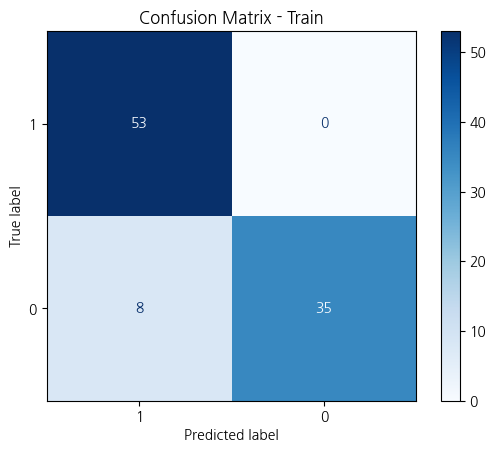

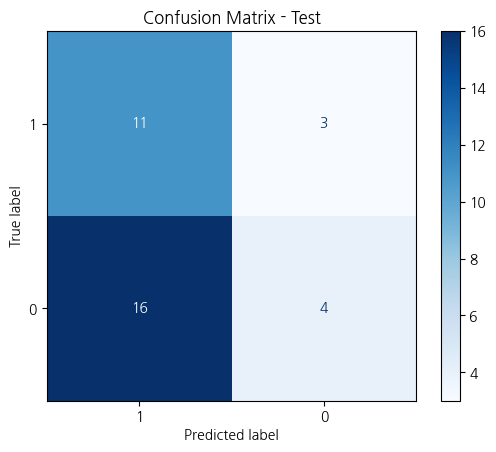

In [60]:
print("훈련 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_train, y_train)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_train, model.predict(x_train),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_train, model.predict(x_train),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_train, model.predict_proba(x_train), multi_class='ovr') ) , end='\n')


label=['1', '0'] # 라벨 설정
plot = plot_confusion_matrix(model, # 분류 모델
                             x_train, y_train, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Train')



print("테스트 세트 ")
print(" - 정확도(acc)         : {:.3f}".format(model.score(x_test, y_test)))
print(" - 정밀도(precision)   : {:.3f}".format( precision_score(y_test, model.predict(x_test),average= "macro") ))
print(" - 재현율(recall)      : {:.3f}".format( recall_score(y_test, model.predict(x_test),average= "macro") ))
# print(" - AUC 점수            : {:.3f}".format( roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') ) , end='\n')


label=['1', '0'] # 라벨 설정
plot = plot_confusion_matrix(model, # 분류 모델
                             x_test, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix - Test')